## Imports

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# ! pip install aif360
# ! pip install cvxpy
# ! pip install BlackBoxAuditing

# import aif360
!pip uninstall numpy
!pip install numpy
! pip install ctgan
! pip install --upgrade category_encoders


# ! pip install table_evaluator
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import category_encoders as ce
import math
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, confusion_matrix
import os
from statistics import mean
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from datetime import datetime
import pprint
import json


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Found existing installation: numpy 1.25.1
Uninstalling numpy-1.25.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-7a851222.3.23.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.1
  Using cached numpy-1.25.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.6 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.7 requires jax>=0.4.6, but you have jax 0.3.25 which is incompatible.
flax 0.7.0 requires jax>=0.4.2, but you have jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Record the start time
start_time = time.time()

## Fairness metrics and functions


In [ ]:
def print_metrics(y_gt, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_gt, y_pred).ravel()
    print('conf matrix:\n ', confusion_matrix(y_gt, y_pred) ,
          '\naccuracy: ', (tp+tn)/(tp+tn+fn+fp),
          'precision: ', tp/(tp+fp),
          'recall: ', tp/(tp+fn),
          'fpr: ', fp/(fp+tn),
          'tpr: ', tp /(tp + fn),
          'fn+fp', fn+fp)
    #returm fpr, tpr, accuracy
    return fp/(fp+tn), tp /(tp + fn), (tp+tn)/(tp+tn+fn+fp)

# bias metric - equal opportunity difference
def opportunity_diff_tpr(tpr1, tpr2):
    return abs(tpr1-tpr2)

# bias metric - equal opportunity difference
def opportunity_diff_fpr(fpr1, fpr2):
    return abs(fpr1-fpr2)

# bias metric - avarage absolute odds difference
def odds_diff(tpr1, tpr2, fpr1, fpr2):
    return 0.5*(abs(tpr2-tpr1) + abs(fpr2-fpr1))

# bias metric - statistical parity difference
def parity_diff(y_pred_0, y_pred_1):
    return abs(len(y_pred_0)/(len(y_pred_0)+len(y_pred_1)) - len(y_pred_1)/(len(y_pred_1)+len(y_pred_0)))


    # bias metric - Disparate impact
def disparate_impact(y_pred_0, y_pred_1):
    return min((len(y_pred_0)/len(y_pred_0+y_pred_1)) / (len(y_pred_1)/len(y_pred_1+len(y_pred_0)))
    ,(len(y_pred_1)/len(y_pred_0+y_pred_1)) / (len(y_pred_0)/len(y_pred_1+len(y_pred_0))))

In [ ]:
# calculate the bias of divided dataset by the privileged feature
def calc_bias(data,y, priv_feature,y_pred, experiment_text):
    data_full =  pd.concat([data, y], axis=1)
    data_full['y_pred'] = y_pred

    label = TARGET_COL
    print('performance for whole ds:'+ experiment_text)
    fpr, tpr, acc = print_metrics(data_full[TARGET_COL], data_full['y_pred'] )

    feature_cat_list = list(data[priv_feature].unique())
    #print(feature_cat_list)
    valid_cat0 = data_full[data_full[priv_feature]==feature_cat_list[0]]
    valid_cat1 = data_full[data_full[priv_feature]==feature_cat_list[1]]
    print('performance for 0 sub-group:')
    fpr_0, tpr_0 , acc_0 = print_metrics(valid_cat0[TARGET_COL], valid_cat0['y_pred'])
    print('performance for 1 sub-group:')

    fpr_1, tpr_1, acc_1 = print_metrics(valid_cat1[TARGET_COL], valid_cat1['y_pred'])
    op_diff = opportunity_diff_tpr(tpr_0, tpr_1)
    op_diff_fpr = opportunity_diff_fpr(fpr_0, fpr_1)
    od_diff = odds_diff(tpr_0, tpr_1, fpr_0, fpr_1)
    par_diff = parity_diff(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    dis_impact = disparate_impact(valid_cat0[valid_cat0['y_pred']==1], valid_cat1[valid_cat1['y_pred']==1])
    print('bias metrics:')
    print('equal opportunity for tpr: (close to 0)', op_diff)
    print('equal opportunity for fpr: (close to 0)', op_diff_fpr)
    print('avarage absolute odds difference: (close to 0)',od_diff)
    print('statistical parity difference: (close to 0) ',par_diff)
    print('disparate_impact: (close to 1) ',dis_impact)

#     # Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
#     fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#     # Bar colors
#     colors = ['blue', 'orange']

#     # Plot 1 - orig_data_one_priv and orig_data_one_non_priv
#     axs[0].bar(['priv', 'non_priv'], [tpr_0, tpr_1], color=colors)
#     axs[0].set_xlabel('Data Type')
#     axs[0].set_ylabel('Count')
#     axs[0].set_title('TPR(maximize)')

#     # Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
#     axs[1].bar(['priv', 'non_priv'], [fpr_0, fpr_1], color=colors)
#     axs[1].set_xlabel('Data Type')
#     axs[1].set_ylabel('Count')
#     axs[1].set_title('FPR(minimize)')

#     # Adjust spacing between subplots
#     plt.subplots_adjust(wspace=0.4)

#     # Show the plots
#     plt.show()

    return (op_diff,op_diff_fpr, od_diff,par_diff ,dis_impact,acc)

In [ ]:
def fairness_metrics_roc_auc(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    std_op = np.std(op_list)
    op_str = f"{mean(op_list):.3f} ± {std_op:.3f}"

    std_op_f = np.std(op_f_list)
    op_f_str = f"{mean(op_f_list):.3f} ± {std_op_f:.3f}"

    std_od = np.std(od_list)
    od_str = f"{mean(od_list):.3f} ± {std_od:.3f}"

    std_par_dif = np.std(par_dif_list)
    par_dif_str = f"{mean(par_dif_list):.3f} ± {std_par_dif:.3f}"

    std_dis_impact = np.std(dis_impact_list)
    dis_imp_str = f"{mean(dis_impact_list):.3f} ± {std_dis_impact:.3f}"


    std_acc = np.std(acc_list)
    acc_str = f"{mean(acc_list):.3f} ± {std_acc:.3f}"
    time_elapsed_baseline = datetime.now() - start_time
    plot_roc_curve(fprs, tprs);
    pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
    print('Accaracy list : ', acc_list)
    print('equal opportunity for tpr : ', op_list)
    print('equal opportunity for fpr : ',op_f_list)
    print('odds difference list : ' , od_list)
    print('The mean accuracy is ', acc_str)
    print('The mean equal opportunity for tpr: (close to 0)', op_str)
    print('The mean equal opportunity for fpr: (close to 0)', op_f_str)
    print('The mean odds difference: (close to 0)',od_str)
    print('The mean parity difference: (close to 0)', par_dif_str)
    print('The mean disperate impact: (close to 1)',dis_imp_str)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

In [ ]:
def fairness_metrics_roc_auc_no_print(data , y):
    clf = RandomForestClassifier(n_estimators=10, max_depth=5)

    cv = StratifiedKFold(n_splits=5, random_state=1234, shuffle=True)
    results = pd.DataFrame(columns=['training_score', 'test_score'])

    fprs, tprs, scores, op_list ,op_f_list, od_list ,par_dif_list,dis_impact_list, acc_list = [], [], [], [],[], [], [],[],[]

    start_time = datetime.now()
    for (train, test), i in zip(cv.split(data, y), range(5)):
        clf.fit(data.iloc[train], y.iloc[train])
        _, _, auc_score_train = compute_roc_auc(train,clf, data, y)
        fpr, tpr, auc_score = compute_roc_auc(test,clf, data, y)
        scores.append((auc_score_train, auc_score))
        fprs.append(fpr)
        tprs.append(tpr)
        y_pred = clf.predict(data.iloc[test])
        o_p, o_p_fpr, o_d ,par_dif, dis_impact, acc_ = calc_bias(data.iloc[test],  y.iloc[test], PRIV_FEATURE,y_pred, 'subexperiment - baseline Ensemble'+' model:'+str(i))
        acc_list.append(acc_)
        op_list.append(o_p)
        op_f_list.append(o_p_fpr)
        od_list.append(o_d)
        par_dif_list.append(par_dif)
        dis_impact_list.append(dis_impact)

    return acc_list, op_list, op_f_list ,od_list,par_dif_list , dis_impact_list

## Roc & AUC functions¶


In [ ]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""

    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs, acc = [], []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))

    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)

    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index,clf ,data, y):
    y_predict = clf.predict_proba(data.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

## Datasets & Params¶


In [ ]:
# choose dataset
#DATASET_NAME = 'ADULT_SEX'
#DATASET_NAME = 'ADULT_RACE'
#DATASET_NAME ='COMPAS_RACE_AM'
#DATASET_NAME = 'COMPAS_SEX'
DATASET_NAME='CREDIT_SEX'
#DATASET_NAME = 'BANK_AGE'



In [ ]:
# upload kaggle.json file using user prompt
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

!mkdir /root/.kaggle/
# Installing the Kaggle package
!pip install kaggle

#Important Note: complete this with your own key - after running this for the first time remmember to **remove** your API_KEY
api_token = {"username":"guyrozenblatt","key":"e2ba3aff97edbcc7b8ab392e91dd8c65"}


# creating kaggle.json file with the personal API-Key details
# You can also put this file on your Google Drive
with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json


!mkdir ./datasets/compastwoyears/compas-scores-two-years_v1.csv


Saving german_credit_data.csv to german_credit_data.csv
User uploaded file "german_credit_data.csv" with length 53393 bytes
mv: cannot stat 'kaggle.json': No such file or directory
mkdir: cannot create directory ‘/root/.kaggle/’: File exists
mkdir: cannot create directory ‘./datasets/compastwoyears/compas-scores-two-years_v1.csv’: No such file or directory


In [ ]:
if DATASET_NAME == 'ADULT_SEX':
    TARGET_COL = 'income'
    PRIV_FEATURE = "sex"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    privileged_groups = [{'sex': 1}] # Male
    unprivileged_groups = [{'sex': 0}] # Female

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']


elif DATASET_NAME == 'ADULT_RACE':
    TARGET_COL = 'income'
    PRIV_FEATURE = "black"
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 1
    orig_data = pd.read_csv('/content/adult.csv')
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == '<=50K' else 1)
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1,0)
    orig_data['black'] = np.where(orig_data['race'] == 'Black', 0,1)
    orig_data.replace('?',np.nan,inplace = True)
    orig_data.dropna(how='any',inplace = True)
    orig_data.drop_duplicates()
    orig_data.reset_index(inplace=True, drop=True)

    feature_columns = ['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country', 'black']

    CATEGORICAL = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'native.country']

elif DATASET_NAME =='COMPAS_RACE_AM':
    orig_data = pd.read_csv('/content/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'am'
#     PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']



elif DATASET_NAME =='COMPAS_SEX':
    orig_data = pd.read_csv('../input/compastwoyears/compas-scores-two-years_v1.csv')
    orig_data = orig_data[((orig_data['days_b_screening_arrest'] <=30) &
      (orig_data['days_b_screening_arrest'] >= -30) &
      (orig_data['is_recid'] != -1) &
      (orig_data['c_charge_degree'] != 'O') &
      (orig_data['score_text'] != 'N/A')
     )]
    TARGET_COL = 'two_year_recid'
    orig_data['sex'] = np.where(orig_data['sex'] == 'Male', 1, 0)
    orig_data['am'] = np.where(orig_data['race'] == 'African-American', 1,0)
    PRIV_FEATURE = 'sex'
    PRIV_CLASS = 0
    PRIV_VALUE_FEATURE = 0
    feature_columns = ['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score','am']
    CATEGORICAL = [ 'age_cat', 'race', 'c_charge_degree', 'score_text']


elif DATASET_NAME == 'CREDIT_SEX':
    orig_data = pd.read_csv('/content/german_credit_data.csv')
    TARGET_COL = 'Risk'
    PRIV_FEATURE = 'Sex'
    PRIV_CLASS = 1
    PRIV_VALUE_FEATURE = 0
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'bad' else 1)
    orig_data['Sex'] = np.where(orig_data['Sex'] == 'male', 0,1)
    orig_data = orig_data.drop(["Unnamed: 0"],axis=1)
    orig_data['young'] = orig_data['Age'].apply(lambda x: 0 if x < 25 else 1)
    CATEGORICAL = ['Housing', 'Saving accounts' , 'Checking account', 'Purpose']
    feature_columns = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account','Credit amount', 'Duration', 'Purpose']

elif DATASET_NAME =='BANK_AGE':
    orig_data = pd.read_csv('/content/bank.csv')
    TARGET_COL = 'deposit'
    orig_data[TARGET_COL] = orig_data[TARGET_COL].apply(lambda x: 0 if x == 'no' else 1)

    orig_data['age_cat'] = np.where(((pd.to_numeric(orig_data['age']) > 65) |  (pd.to_numeric(orig_data['age']) < 25)), 0,1)
    PRIV_FEATURE = 'age_cat'
    PRIV_VALUE_FEATURE = 0
    PRIV_CLASS = 1
    feature_columns = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'age_cat',
       'previous', 'poutcome']
    CATEGORICAL = [ 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

In [ ]:
orig_data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,young
0,67,0,2,own,NaN,little,1169,6,radio/TV,1,1
1,22,1,2,own,little,moderate,5951,48,radio/TV,0,0
2,49,0,1,own,little,NaN,2096,12,education,1,1
3,45,0,2,free,little,little,7882,42,furniture/equipment,1,1
4,53,0,2,free,little,little,4870,24,car,0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1,own,little,NaN,1736,12,furniture/equipment,1,1
996,40,0,3,own,little,little,3857,30,car,1,1
997,38,0,2,own,little,NaN,804,12,radio/TV,1,1
998,23,0,2,free,little,little,1845,45,radio/TV,0,0


## Data_Visualization

In [ ]:
#Based on class
orig_data_one , orig_data_zero = [x for _, x in orig_data.groupby(orig_data[TARGET_COL] == 0)]

#Based on priv feature
orig_data_one_priv, orig_data_one_non_priv = [x for _, x in orig_data_one.groupby(orig_data_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
orig_data_zero_priv, orig_data_zero_non_priv = [x for _, x in orig_data_zero.groupby(orig_data_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(orig_data_one_priv.shape,orig_data_one_non_priv.shape,orig_data_zero_priv.shape,orig_data_zero_non_priv.shape)

(499, 11) (201, 11) (191, 11) (109, 11)


In [ ]:
maximum = max(orig_data_zero_priv.shape,orig_data_zero_non_priv.shape,orig_data_one_priv.shape,orig_data_one_non_priv.shape)
if maximum == orig_data_zero_priv.shape:
    print("orig_data_zero_priv is maximum")
if maximum == orig_data_zero_non_priv.shape:
    print("orig_data_zero_non_priv is maximum")
if maximum == orig_data_one_priv.shape:
    print("orig_data_one_priv is maximum")
if maximum == orig_data_one_non_priv.shape:
    print("orig_data_one_non_priv is maximum")

orig_data_one_priv is maximum


In [ ]:
maximum = maximum[0]
print(maximum)

499


In [ ]:
orig_data_zero_priv.shape[0]

191

In [ ]:
orig_data_one_non_priv

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,young
12,22,1,2,own,little,moderate,1567,12,radio/TV,1,0
14,28,1,2,rent,little,little,1403,15,car,1,1
27,42,1,2,rent,rich,rich,409,12,radio/TV,1,1
34,33,1,3,own,little,rich,1474,12,furniture/equipment,1,1
45,35,1,3,own,little,NaN,1393,11,car,1,1
...,...,...,...,...,...,...,...,...,...,...,...
976,64,1,2,own,little,moderate,753,6,radio/TV,1,1
982,28,1,3,own,moderate,rich,2923,21,car,1,1
985,25,1,2,rent,little,little,1433,15,furniture/equipment,1,1
987,64,1,2,own,moderate,NaN,1409,13,radio/TV,1,1


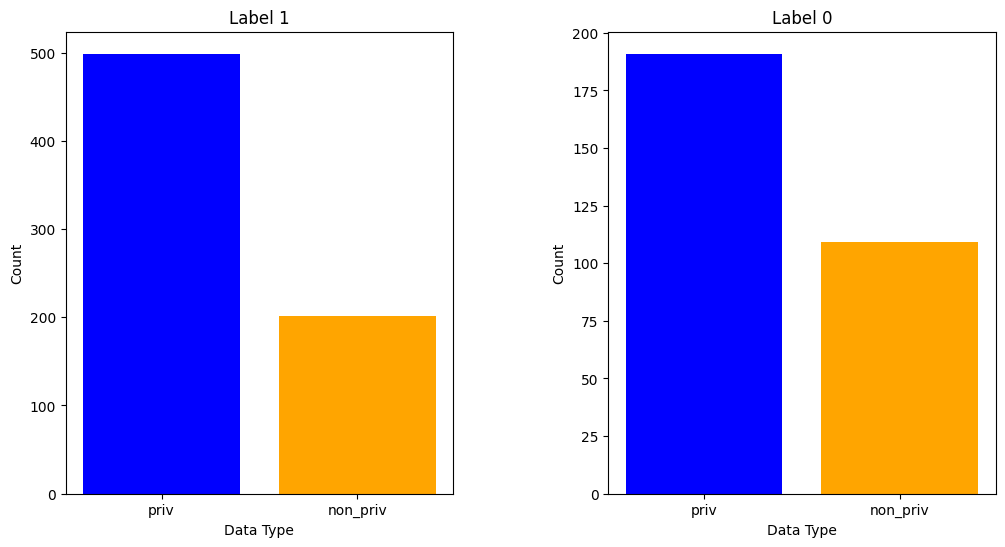

In [ ]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [orig_data_one_priv.shape[0], orig_data_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [orig_data_zero_priv.shape[0], orig_data_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')


# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

In [ ]:
orig_data

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,young
0,67,0,2,own,NaN,little,1169,6,radio/TV,1,1
1,22,1,2,own,little,moderate,5951,48,radio/TV,0,0
2,49,0,1,own,little,NaN,2096,12,education,1,1
3,45,0,2,free,little,little,7882,42,furniture/equipment,1,1
4,53,0,2,free,little,little,4870,24,car,0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,31,1,1,own,little,NaN,1736,12,furniture/equipment,1,1
996,40,0,3,own,little,little,3857,30,car,1,1
997,38,0,2,own,little,NaN,804,12,radio/TV,1,1
998,23,0,2,free,little,little,1845,45,radio/TV,0,0


In [ ]:
# dataset for training
orig_data.dropna(thresh=len(feature_columns)/2, inplace=True)
orig_data.reset_index(drop=True, inplace=True)

y_orig = orig_data[TARGET_COL]
# y_orig = orig_data[TARGET_COL].to_frame()

y_orig.dropna(inplace=True)

orig_data = orig_data.loc[:, feature_columns]
# data = data[feature_columns]
encoder = ce.TargetEncoder(cols=CATEGORICAL)

encoder.fit(orig_data, y_orig)
orig_data_encoded = encoder.transform(orig_data)

In [ ]:
orig_dataset = pd.concat([orig_data, y_orig], axis=1)


## Acc, fairness metrics and roc & auc for original dataset

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[ 14  46]
 [ 11 129]] 
accuracy:  0.715 precision:  0.7371428571428571 recall:  0.9214285714285714 fpr:  0.7666666666666667 tpr:  0.9214285714285714 fn+fp 57
performance for 0 sub-group:
conf matrix:
  [[ 7 28]
 [ 6 91]] 
accuracy:  0.7424242424242424 precision:  0.7647058823529411 recall:  0.9381443298969072 fpr:  0.8 tpr:  0.9381443298969072 fn+fp 34
performance for 1 sub-group:
conf matrix:
  [[ 7 18]
 [ 5 38]] 
accuracy:  0.6617647058823529 precision:  0.6785714285714286 recall:  0.8837209302325582 fpr:  0.72 tpr:  0.8837209302325582 fn+fp 23
bias metrics:
equal opportunity for tpr: (close to 0) 0.05442339966434906
equal opportunity for fpr: (close to 0) 0.08000000000000007
avarage absolute odds difference: (close to 0) 0.06721169983217457
statistical parity difference: (close to 0)  0.36000000000000004
disparate_impact: (close to 1)  0.15058823529411766
performance for whole ds:subexperiment - basel

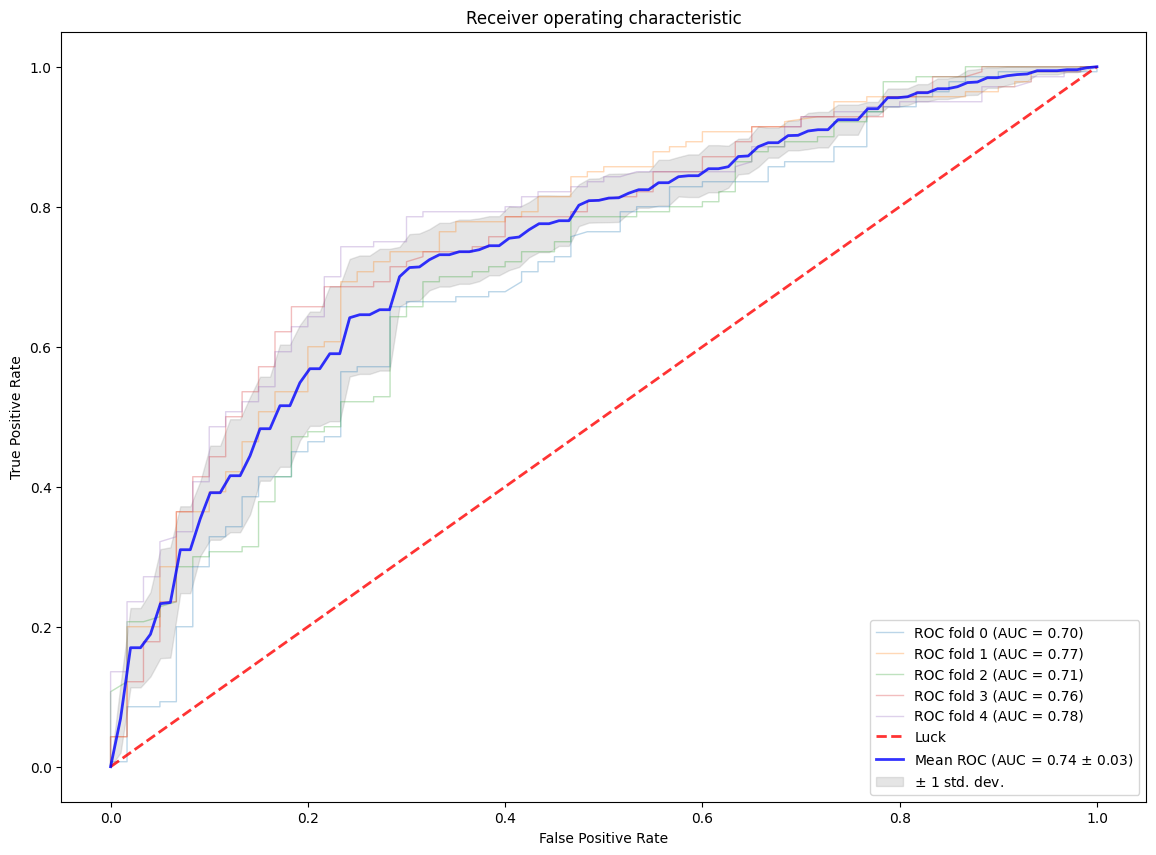

Accaracy list :  [0.715, 0.745, 0.71, 0.735, 0.73]
equal opportunity for tpr :  [0.05442339966434906, 0.06344696969696972, 0.05102040816326536, 0.12930077691453945, 0.026831785345717174]
equal opportunity for fpr :  [0.08000000000000007, 0.06698564593301437, 0.025000000000000022, 0.30000000000000004, 0.1004784688995215]
odds difference list :  [0.06721169983217457, 0.06521630781499205, 0.03801020408163269, 0.21465038845726975, 0.06365512712261934]
The mean accuracy is  0.727 ± 0.013
The mean equal opportunity for tpr: (close to 0) 0.065 ± 0.034
The mean equal opportunity for fpr: (close to 0) 0.114 ± 0.096
The mean odds difference: (close to 0) 0.090 ± 0.063
The mean parity difference: (close to 0) 0.427 ± 0.069
The mean disperate impact: (close to 1) 0.186 ± 0.094


In [ ]:
orig_acc ,orig_op_diff, orig_op_diff_fpr, orig_od_diff, orig_par_diff , orig_dis_impact  = fairness_metrics_roc_auc(orig_data_encoded, y_orig)

  ## CTGANfor each group

In [ ]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1


print(zero_priv_toincrease,zero_nonpriv_toincresed,one_priv_toincresed,one_nonpriv_toincresed)

308 390 0 298


# CTGAN On Priv Target Group

In [ ]:
from ctgan import CTGAN

# Fit CTGAN for orig_data_zero_priv

ctgan_zero_priv = CTGAN(verbose=True)
ctgan_zero_priv.fit(orig_data_zero_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_zero_non_priv

ctgan_zero_nonpriv = CTGAN(verbose=True)
ctgan_zero_nonpriv.fit(orig_data_zero_non_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_priv

ctgan_one_priv = CTGAN(verbose=True)
ctgan_one_priv.fit(orig_data_one_priv , CATEGORICAL, epochs = 200)

# Fit CTGAN for orig_data_one_non_priv

ctgan_one_nonpriv = CTGAN(verbose=True)
ctgan_one_nonpriv.fit(orig_data_one_non_priv , CATEGORICAL, epochs = 200)



/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e619ffdad40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py

Epoch 1, Loss G:  1.5575,Loss D:  0.0017
Epoch 2, Loss G:  1.5191,Loss D:  0.0001
Epoch 3, Loss G:  1.5114,Loss D: -0.0075
Epoch 4, Loss G:  1.5068,Loss D: -0.0155
Epoch 5, Loss G:  1.4402,Loss D: -0.0523
Epoch 6, Loss G:  1.5047,Loss D: -0.0799
Epoch 7, Loss G:  1.4628,Loss D: -0.1251
Epoch 8, Loss G:  1.4285,Loss D: -0.0998
Epoch 9, Loss G:  1.3925,Loss D: -0.1369
Epoch 10, Loss G:  1.3622,Loss D: -0.1782
Epoch 11, Loss G:  1.3783,Loss D: -0.1841
Epoch 12, Loss G:  1.3926,Loss D: -0.2076
Epoch 13, Loss G:  1.3356,Loss D: -0.3039
Epoch 14, Loss G:  1.3046,Loss D: -0.2559
Epoch 15, Loss G:  1.2968,Loss D: -0.3166
Epoch 16, Loss G:  1.1419,Loss D: -0.3137
Epoch 17, Loss G:  1.1420,Loss D: -0.3769
Epoch 18, Loss G:  1.0014,Loss D: -0.4426
Epoch 19, Loss G:  0.9715,Loss D: -0.3909
Epoch 20, Loss G:  0.8617,Loss D: -0.3257
Epoch 21, Loss G:  0.7369,Loss D: -0.3460
Epoch 22, Loss G:  0.7344,Loss D: -0.2247
Epoch 23, Loss G:  0.5164,Loss D: -0.3075
Epoch 24, Loss G:  0.5179,Loss D: -0.2650
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.5778,Loss D: -0.0021


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


Epoch 2, Loss G:  1.5757,Loss D:  0.0083
Epoch 3, Loss G:  1.5447,Loss D:  0.0079
Epoch 4, Loss G:  1.5365,Loss D: -0.0072
Epoch 5, Loss G:  1.5108,Loss D: -0.0230
Epoch 6, Loss G:  1.4973,Loss D: -0.0277
Epoch 7, Loss G:  1.5271,Loss D: -0.0111
Epoch 8, Loss G:  1.4414,Loss D: -0.0588
Epoch 9, Loss G:  1.4472,Loss D: -0.0308
Epoch 10, Loss G:  1.4397,Loss D: -0.0742
Epoch 11, Loss G:  1.3406,Loss D: -0.0713
Epoch 12, Loss G:  1.3862,Loss D: -0.1086
Epoch 13, Loss G:  1.3324,Loss D: -0.0746
Epoch 14, Loss G:  1.3158,Loss D: -0.0729
Epoch 15, Loss G:  1.2019,Loss D: -0.1157
Epoch 16, Loss G:  1.2084,Loss D: -0.1914
Epoch 17, Loss G:  1.1665,Loss D: -0.1056
Epoch 18, Loss G:  1.1217,Loss D: -0.1282
Epoch 19, Loss G:  1.0896,Loss D: -0.1386
Epoch 20, Loss G:  1.0066,Loss D: -0.2335
Epoch 21, Loss G:  0.9752,Loss D: -0.1353
Epoch 22, Loss G:  0.8941,Loss D: -0.1144
Epoch 23, Loss G:  0.9201,Loss D: -0.0935
Epoch 24, Loss G:  0.8500,Loss D: -0.0116
Epoch 25, Loss G:  0.7621,Loss D: -0.0828


/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.7033,Loss D:  0.0122
Epoch 2, Loss G:  1.6912,Loss D: -0.0093
Epoch 3, Loss G:  1.6943,Loss D: -0.0143
Epoch 4, Loss G:  1.6739,Loss D: -0.0329
Epoch 5, Loss G:  1.6495,Loss D: -0.0528
Epoch 6, Loss G:  1.7106,Loss D: -0.0816
Epoch 7, Loss G:  1.6321,Loss D: -0.0644
Epoch 8, Loss G:  1.6611,Loss D: -0.0857
Epoch 9, Loss G:  1.6455,Loss D: -0.0537
Epoch 10, Loss G:  1.6909,Loss D: -0.1054
Epoch 11, Loss G:  1.5818,Loss D: -0.1006
Epoch 12, Loss G:  1.5657,Loss D: -0.1033
Epoch 13, Loss G:  1.5978,Loss D: -0.1464
Epoch 14, Loss G:  1.4960,Loss D: -0.1303
Epoch 15, Loss G:  1.4681,Loss D: -0.0414
Epoch 16, Loss G:  1.4365,Loss D: -0.1041
Epoch 17, Loss G:  1.3420,Loss D: -0.1327
Epoch 18, Loss G:  1.3327,Loss D: -0.0981
Epoch 19, Loss G:  1.2891,Loss D: -0.0482
Epoch 20, Loss G:  1.1855,Loss D: -0.0156
Epoch 21, Loss G:  1.1445,Loss D:  0.0461
Epoch 22, Loss G:  1.0632,Loss D: -0.0744
Epoch 23, Loss G:  1.1328,Loss D:  0.0285
Epoch 24, Loss G:  1.0704,Loss D:  0.0107
E

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'mi

Epoch 1, Loss G:  1.5362,Loss D:  0.0175
Epoch 2, Loss G:  1.5757,Loss D: -0.0042
Epoch 3, Loss G:  1.5126,Loss D:  0.0027
Epoch 4, Loss G:  1.4692,Loss D: -0.0457
Epoch 5, Loss G:  1.4625,Loss D: -0.0013
Epoch 6, Loss G:  1.4439,Loss D: -0.0540
Epoch 7, Loss G:  1.4827,Loss D: -0.0173
Epoch 8, Loss G:  1.3559,Loss D: -0.0440
Epoch 9, Loss G:  1.3563,Loss D: -0.0222
Epoch 10, Loss G:  1.3703,Loss D: -0.0510
Epoch 11, Loss G:  1.2520,Loss D: -0.0654
Epoch 12, Loss G:  1.2384,Loss D: -0.0600
Epoch 13, Loss G:  1.2996,Loss D: -0.1331
Epoch 14, Loss G:  1.2424,Loss D: -0.0866
Epoch 15, Loss G:  1.1648,Loss D: -0.1850
Epoch 16, Loss G:  1.0654,Loss D: -0.1153
Epoch 17, Loss G:  1.1499,Loss D: -0.1709
Epoch 18, Loss G:  1.0637,Loss D: -0.1983
Epoch 19, Loss G:  1.0162,Loss D: -0.1985
Epoch 20, Loss G:  0.8040,Loss D: -0.1441
Epoch 21, Loss G:  0.8759,Loss D: -0.1514
Epoch 22, Loss G:  0.7897,Loss D: -0.2791
Epoch 23, Loss G:  0.6279,Loss D: -0.1795
Epoch 24, Loss G:  0.5551,Loss D: -0.2580
E

In [ ]:
zero_priv_toincrease = maximum - orig_data_zero_priv.shape[0] ## where class is 0 attribute is 1
zero_nonpriv_toincresed = maximum - orig_data_zero_non_priv.shape[0] ## where class is 1 attribute is 0
one_priv_toincresed = maximum - orig_data_one_priv.shape[0] ## where class is 1 attribute is 1
one_nonpriv_toincresed = maximum - orig_data_one_non_priv.shape[0] ## where class is 1 attribute is 1

#create samples using ctgan with zero_priv
zero_priv_samples = ctgan_zero_priv.sample(zero_priv_toincrease)


#create samples using ctgan with zero_nonpriv
zero_nonpriv_samples = ctgan_zero_nonpriv.sample(zero_nonpriv_toincresed)


#create samples using ctgan with one_priv
one_priv_samples = ctgan_one_priv.sample(one_priv_toincresed)


#create samples using ctgan with zero_priv
one_nonpriv_samples = ctgan_one_nonpriv.sample(one_nonpriv_toincresed)



In [ ]:
Upsampled_Dataset = pd.concat([orig_dataset, zero_priv_samples, zero_nonpriv_samples, one_priv_samples, one_nonpriv_samples], ignore_index=True)

Upsampled_Dataset = Upsampled_Dataset.reset_index()


In [ ]:
Upsampled_Dataset

,index,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,young
0,0,67,0,2,own,NaN,little,1169,6,radio/TV,1,NaN
1,1,22,1,2,own,little,moderate,5951,48,radio/TV,0,NaN
2,2,49,0,1,own,little,NaN,2096,12,education,1,NaN
3,3,45,0,2,free,little,little,7882,42,furniture/equipment,1,NaN
4,4,53,0,2,free,little,little,4870,24,car,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1991,1991,21,1,2,rent,little,NaN,4126,15,car,1,0.0
1992,1992,18,1,1,own,little,NaN,5324,8,car,1,1.0
1993,1993,13,1,1,free,quite rich,NaN,5018,17,education,1,0.0
1994,1994,45,1,2,rent,quite rich,little,5941,7,radio/TV,1,0.0


In [ ]:
Upsampled_df_features = Upsampled_Dataset.loc[:, feature_columns]

Upsampled_df_features = encoder.transform(Upsampled_df_features)
Upsampled_df_features

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,0,2,0.739130,0.825137,0.507299,1169,6,0.778571
1,22,1,2,0.739130,0.640133,0.609665,5951,48,0.778571
2,49,0,1,0.739130,0.640133,0.883249,2096,12,0.611952
3,45,0,2,0.592609,0.640133,0.507299,7882,42,0.679558
4,53,0,2,0.592609,0.640133,0.507299,4870,24,0.685460
...,...,...,...,...,...,...,...,...,...
1991,21,1,2,0.608939,0.640133,0.883249,4126,15,0.685460
1992,18,1,1,0.739130,0.640133,0.883249,5324,8,0.685460
1993,13,1,1,0.592609,0.823718,0.883249,5018,17,0.611952
1994,45,1,2,0.608939,0.823718,0.507299,5941,7,0.778571


performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[149  51]
 [ 52 148]] 
accuracy:  0.7425 precision:  0.7437185929648241 recall:  0.74 fpr:  0.255 tpr:  0.74 fn+fp 103
performance for 0 sub-group:
conf matrix:
  [[74 29]
 [30 80]] 
accuracy:  0.7230046948356808 precision:  0.7339449541284404 recall:  0.7272727272727273 fpr:  0.2815533980582524 tpr:  0.7272727272727273 fn+fp 59
performance for 1 sub-group:
conf matrix:
  [[75 22]
 [22 68]] 
accuracy:  0.7647058823529411 precision:  0.7555555555555555 recall:  0.7555555555555555 fpr:  0.2268041237113402 tpr:  0.7555555555555555 fn+fp 44
bias metrics:
equal opportunity for tpr: (close to 0) 0.028282828282828243
equal opportunity for fpr: (close to 0) 0.05474927434691221
avarage absolute odds difference: (close to 0) 0.041516051314870225
statistical parity difference: (close to 0)  0.09547738693467339
disparate_impact: (close to 1)  0.3734267668618321
performance for whole ds:subexperiment - baseline Ensem

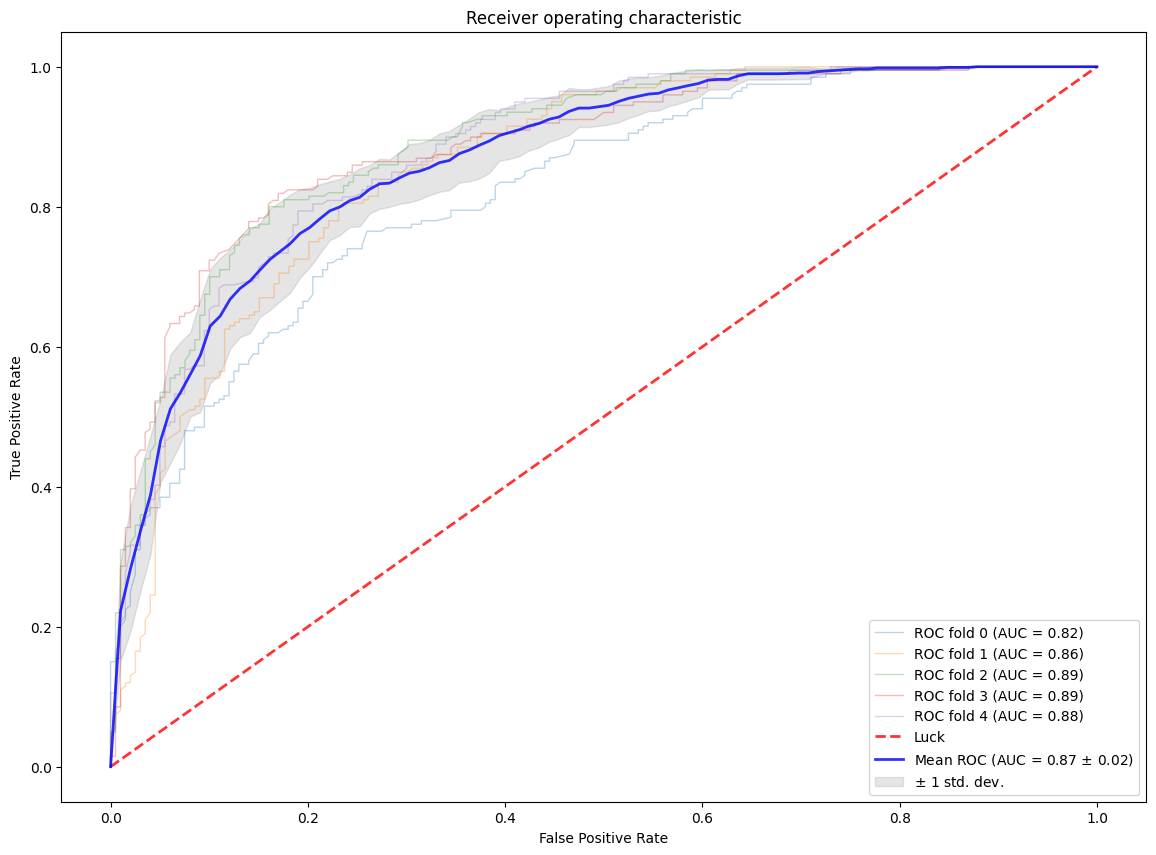

Accaracy list :  [0.7425, 0.7744360902255639, 0.8145363408521303, 0.7919799498746867, 0.7944862155388471]
equal opportunity for tpr :  [0.028282828282828243, 0.10576923076923073, 0.052334943639291476, 0.005960800161648794, 0.1475525889967637]
equal opportunity for fpr :  [0.05474927434691221, 0.032261326860841405, 0.018383838383838363, 0.036833149834851364, 0.03121248499399759]
odds difference list :  [0.041516051314870225, 0.06901527881503607, 0.03535939101156492, 0.02139697499825008, 0.08938253699538065]
The mean accuracy is  0.784 ± 0.024
The mean equal opportunity for tpr: (close to 0) 0.068 ± 0.052
The mean equal opportunity for fpr: (close to 0) 0.035 ± 0.012
The mean odds difference: (close to 0) 0.051 ± 0.025
The mean parity difference: (close to 0) 0.077 ± 0.033
The mean disperate impact: (close to 1) 0.429 ± 0.051


In [ ]:
y_upsampled = Upsampled_Dataset[TARGET_COL]

# Check fairness metrics again
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Store metrics values
# op_diff_values.append(mean(debias_op_diff))
# dis_impact_values.append(mean(debias_dis_impact))
# debias_acc_values.append(mean(debias_acc))
# debias_odds_diff_values.append(mean(debias_od_diff))
# alfa_counter += 1
# print('alfa counter is :',alfa_counter)
# print ('debias_op_diff is {} , orig_op_diff is {}'.format(mean(debias_op_diff), mean(orig_op_diff)))
# print ('debias_dis_impact is {} , orig_dis_impact is {}'.format(mean(debias_dis_impact), mean(orig_dis_impact)) )

In [ ]:
#Based on class
Upsampled_Dataset_one , Upsampled_Dataset_zero = [x for _, x in Upsampled_Dataset.groupby(Upsampled_Dataset[TARGET_COL] == 0)]

#Based on priv feature
Upsampled_df_one_priv, Upsampled_df_one_non_priv = [x for _, x in Upsampled_Dataset_one.groupby(Upsampled_Dataset_one[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]
Upsampled_df_zero_priv, Upsampled_df_zero_non_priv = [x for _, x in Upsampled_Dataset_zero.groupby(Upsampled_Dataset_zero[PRIV_FEATURE] != PRIV_VALUE_FEATURE)]

print(Upsampled_df_one_priv.shape,Upsampled_df_one_non_priv.shape,Upsampled_df_zero_priv.shape,Upsampled_df_zero_non_priv.shape)

(499, 12) (499, 12) (499, 12) (499, 12)


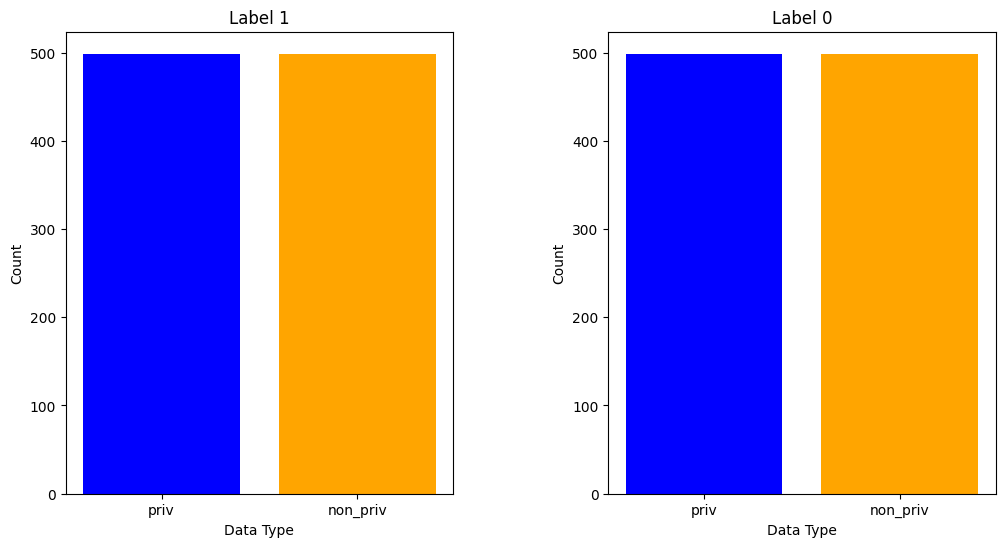

In [ ]:
# Plot for orig_data_one_priv.shape[0] and orig_data_one_non_priv.shape[0]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Bar colors
colors = ['blue', 'orange']

# Plot 1 - orig_data_one_priv and orig_data_one_non_priv
axs[0].bar(['priv', 'non_priv'], [Upsampled_df_one_priv.shape[0], Upsampled_df_one_non_priv.shape[0]], color=colors)
axs[0].set_xlabel('Data Type')
axs[0].set_ylabel('Count')
axs[0].set_title('Label 1')

# Plot 2 - orig_data_zero_priv and orig_data_zero_non_priv
axs[1].bar(['priv', 'non_priv'], [Upsampled_df_zero_priv.shape[0], Upsampled_df_zero_non_priv.shape[0]], color=colors)
axs[1].set_xlabel('Data Type')
axs[1].set_ylabel('Count')
axs[1].set_title('Label 0')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plots
plt.show()

performance for whole ds:subexperiment - baseline Ensemble model:0
conf matrix:
  [[145  55]
 [ 43 157]] 
accuracy:  0.755 precision:  0.7405660377358491 recall:  0.785 fpr:  0.275 tpr:  0.785 fn+fp 98
performance for 0 sub-group:
conf matrix:
  [[74 29]
 [23 87]] 
accuracy:  0.755868544600939 precision:  0.75 recall:  0.7909090909090909 fpr:  0.2815533980582524 tpr:  0.7909090909090909 fn+fp 52
performance for 1 sub-group:
conf matrix:
  [[71 26]
 [20 70]] 
accuracy:  0.7540106951871658 precision:  0.7291666666666666 recall:  0.7777777777777778 fpr:  0.26804123711340205 tpr:  0.7777777777777778 fn+fp 46
bias metrics:
equal opportunity for tpr: (close to 0) 0.013131313131313105
equal opportunity for fpr: (close to 0) 0.01351216094485036
avarage absolute odds difference: (close to 0) 0.013321737038081732
statistical parity difference: (close to 0)  0.09433962264150941
disparate_impact: (close to 1)  0.3747560182173065
performance for whole ds:subexperiment - baseline Ensemble model:1
co

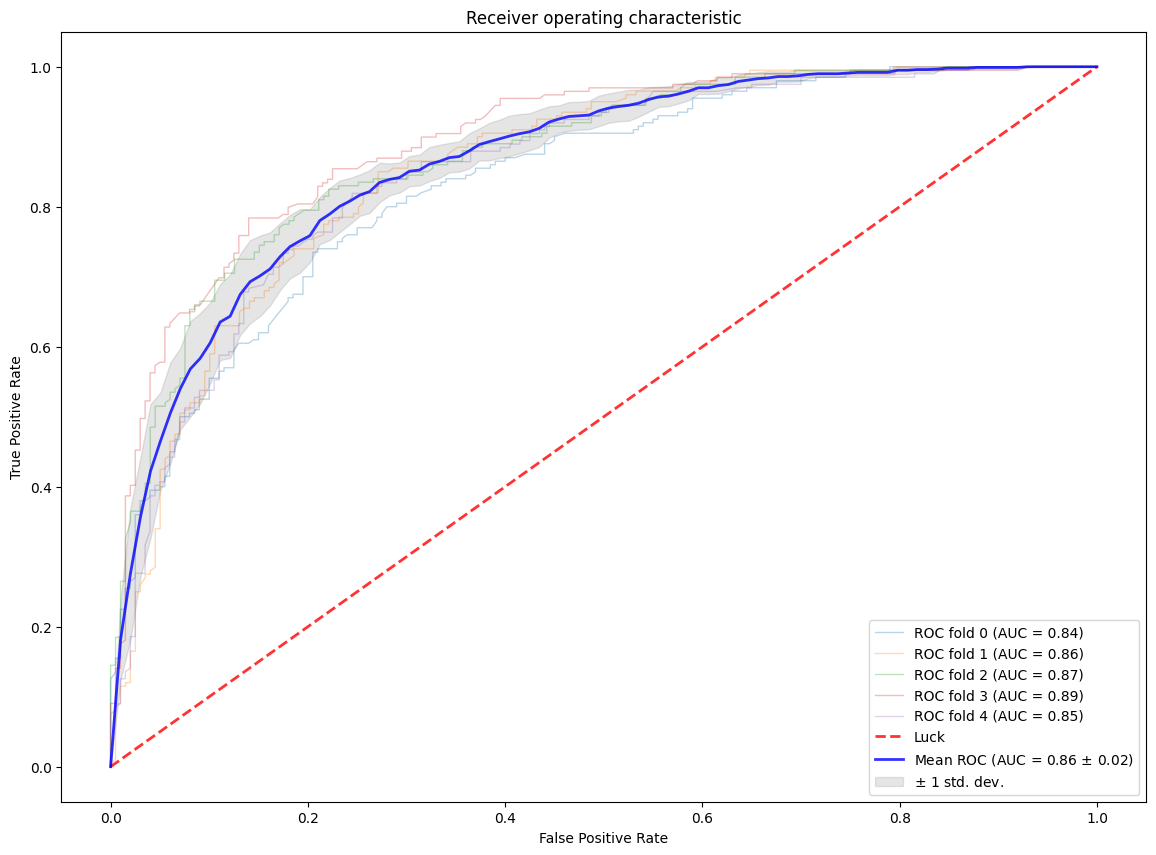

Accaracy list :  [0.755, 0.7769423558897243, 0.7919799498746867, 0.8095238095238095, 0.7694235588972431]
equal opportunity for tpr :  [0.013131313131313105, 0.08413461538461542, 0.16384863123993554, 0.005152556071933656, 0.16980177993527512]
equal opportunity for fpr :  [0.01351216094485036, 0.08151294498381875, 0.0222222222222222, 0.087478730857772, 0.08803521408563425]
odds difference list :  [0.013321737038081732, 0.08282378018421709, 0.09303542673107887, 0.046315643464852826, 0.12891849701045469]
The mean accuracy is  0.781 ± 0.019
The mean equal opportunity for tpr: (close to 0) 0.087 ± 0.071
The mean equal opportunity for fpr: (close to 0) 0.059 ± 0.033
The mean odds difference: (close to 0) 0.073 ± 0.040
The mean parity difference: (close to 0) 0.094 ± 0.034
The mean disperate impact: (close to 1) 0.411 ± 0.050


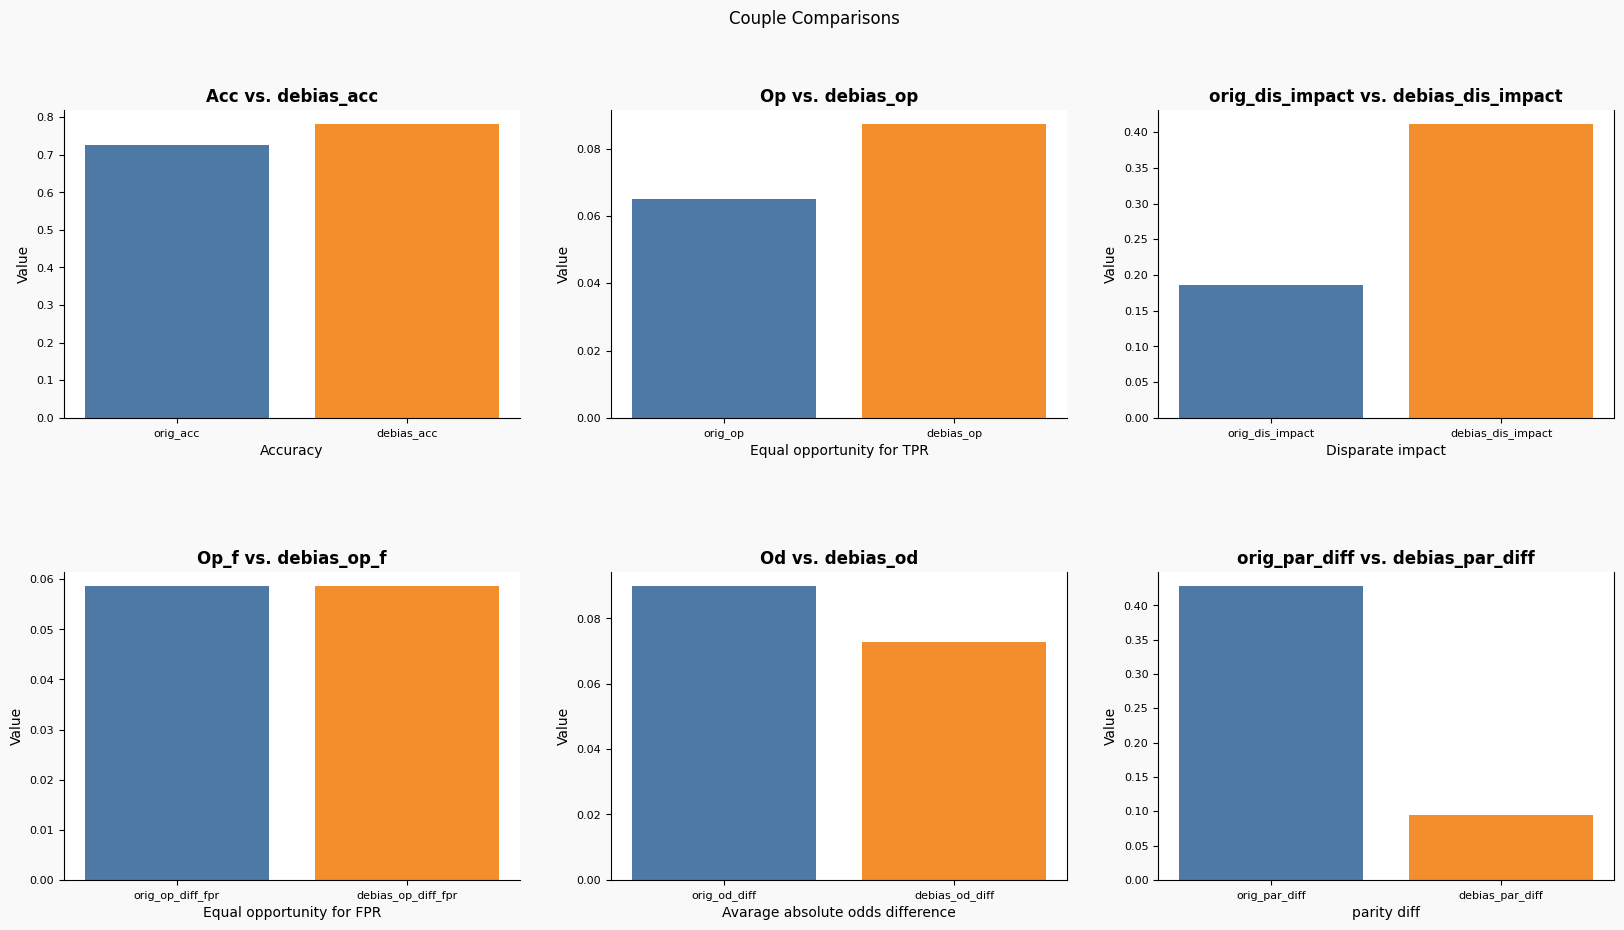

In [ ]:
upsampled_acc, upsampled_op_diff, upsampled_op_diff_fpr, upsampled_od_diff, upsampled_par_diff, upsampled_dis_impact = fairness_metrics_roc_auc(Upsampled_df_features, y_upsampled)

# # Initialize wandb
# wandb.init(project="couple-comparisons")

# Create a bar plot for each couple comparison
fig, ax = plt.subplots(2, 3, figsize=(20, 10), dpi=100)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Couple Comparisons')

# Set background color
fig.patch.set_facecolor('#f9f9f9')

# Acc vs. Pois_acc plot
ax[0, 0].bar(['orig_acc', 'debias_acc'], [mean(orig_acc), mean(upsampled_acc)], color=['#4e79a7', '#f28e2c'])
ax[0, 0].set_title('Acc vs. debias_acc', fontsize=12, fontweight='bold')
ax[0, 0].set_xlabel('Accuracy', fontsize=10)
ax[0, 0].set_ylabel('Value', fontsize=10)
ax[0, 0].tick_params(axis='both', which='major', labelsize=8)
ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)

# Op vs. Pois_op plot
ax[0, 1].bar(['orig_op','debias_op'], [mean(orig_op_diff), mean(upsampled_op_diff)], color=['#4e79a7', '#f28e2c'])
ax[0, 1].set_title('Op vs. debias_op', fontsize=12, fontweight='bold')
ax[0, 1].set_xlabel('Equal opportunity for TPR', fontsize=10)
ax[0, 1].set_ylabel('Value', fontsize=10)
ax[0, 1].tick_params(axis='both', which='major', labelsize=8)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)

# Op_f vs. Pois_op_f plotdebias
ax[1, 0].bar(['orig_op_diff_fpr', 'debias_op_diff_fpr'], [mean(upsampled_op_diff_fpr), mean(upsampled_op_diff_fpr)], color=['#4e79a7', '#f28e2c'])
ax[1, 0].set_title('Op_f vs. debias_op_f', fontsize=12, fontweight='bold')
ax[1, 0].set_xlabel('Equal opportunity for FPR', fontsize=10)
ax[1, 0].set_ylabel('Value', fontsize=10)
ax[1, 0].tick_params(axis='both', which='major', labelsize=8)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)

# Od vs. Pois_od plot
ax[1, 1].bar(['orig_od_diff', 'debias_od_diff'], [mean(orig_od_diff), mean(upsampled_od_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 1].set_title('Od vs. debias_od', fontsize=12, fontweight='bold')
ax[1, 1].set_xlabel('Avarage absolute odds difference', fontsize=10)
ax[1, 1].set_ylabel('Value', fontsize=10)
ax[1, 1].tick_params(axis='both', which='major', labelsize=8)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines

# Od vs. Pois_od plot
ax[1, 2].bar(['orig_par_diff', 'debias_par_diff'], [mean(orig_par_diff), mean(upsampled_par_diff)], color=['#4e79a7', '#f28e2c'])
ax[1, 2].set_title('orig_par_diff vs. debias_par_diff', fontsize=12, fontweight='bold')
ax[1, 2].set_xlabel('parity diff', fontsize=10)
ax[1, 2].set_ylabel('Value', fontsize=10)
ax[1, 2].tick_params(axis='both', which='major', labelsize=8)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines

# Od vs. Pois_od plot
ax[0, 2].bar(['orig_dis_impact', 'debias_dis_impact'], [mean(orig_dis_impact), mean(upsampled_dis_impact)], color=['#4e79a7', '#f28e2c'])
ax[0, 2].set_title('orig_dis_impact vs. debias_dis_impact', fontsize=12, fontweight='bold')
ax[0, 2].set_xlabel('Disparate impact', fontsize=10)
ax[0, 2].set_ylabel('Value', fontsize=10)
ax[0, 2].tick_params(axis='both', which='major', labelsize=8)
ax[0, 2].spines['top'].set_visible(False)
ax[0, 2].spines



In [ ]:
# Record the end time
end_time = time.time()

In [ ]:
# Calculate the elapsed time in minutes
elapsed_time_minutes = (end_time - start_time) / 60
print(f"Elapsed time: {elapsed_time_minutes:.4f} minutes")

Elapsed time: 2.2794 minutes
